In [1]:
import pandas as pd
df = pd.read_csv('temperature.csv')
print(df.head())

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

In [2]:
df = df.iloc[:200000:6]
df = df.drop(columns=['Date Time'])

mean = df.mean()
std = df.std()
df = (df-mean)/std

print(df.head())

    p (mbar)  T (degC)  Tpot (K)  Tdew (degC)    rh (%)  VPmax (mbar)  \
0   0.900080 -1.931243 -1.982008    -1.862774  1.073091     -1.307358   
6   0.897721 -1.886062 -1.936218    -1.779038  1.162756     -1.293054   
12  0.913050 -2.024996 -2.074707    -1.974423  1.085046     -1.334667   
18  0.941348 -2.023866 -2.075824    -1.973027  1.085046     -1.333367   
24  0.962572 -2.067919 -2.121614    -2.051181  1.007336     -1.346371   

    VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
0      -1.473784     -0.798768  -1.476283        -1.478172      2.123687   
6      -1.438047     -0.807030  -1.438763        -1.442890      2.074970   
12     -1.519050     -0.802899  -1.521308        -1.522864      2.226299   
18     -1.519050     -0.802899  -1.517556        -1.522864      2.232418   
24     -1.550021     -0.794637  -1.551324        -1.553442      2.285372   

    wv (m/s)  max. wv (m/s)  wd (deg)  
0  -0.727723      -0.779684 -0.277693  
6  -1.281252      -1.260

In [3]:
import numpy as np

pastDay=30
futureDay=1

X, y = [], []
for i in range(df.shape[0]-futureDay-pastDay):
    X.append(np.array(df.iloc[i:i+pastDay]))
    y.append(np.array(df.iloc[i+pastDay:i+pastDay+futureDay]["T (degC)"]))

X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(33303, 30, 14) (33303, 1)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29972, 30, 14) (3331, 30, 14) (29972, 1) (3331, 1)


In [5]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth =True

#set_session(tf.compat.v1.Session(config=config)) 
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

Using TensorFlow backend.


In [6]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                1000      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,011
Trainable params: 1,011
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(loss="mse", optimizer="adam")
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.1, callbacks=[callback])

Train on 26974 samples, validate on 2998 samples
Epoch 1/1000
26974/26974 [==============================] - 6s 233us/step - loss: 0.2194 - val_loss: 0.0662
Epoch 2/1000
26974/26974 [==============================] - 6s 216us/step - loss: 0.0415 - val_loss: 0.0302
Epoch 3/1000
26974/26974 [==============================] - 6s 219us/step - loss: 0.0224 - val_loss: 0.0198
Epoch 4/1000
26974/26974 [==============================] - 6s 211us/step - loss: 0.0159 - val_loss: 0.0151
Epoch 5/1000
26974/26974 [==============================] - 6s 209us/step - loss: 0.0128 - val_loss: 0.0123
Epoch 6/1000
26974/26974 [==============================] - 6s 215us/step - loss: 0.0110 - val_loss: 0.0109
Epoch 7/1000
26974/26974 [==============================] - 6s 226us/step - loss: 0.0099 - val_loss: 0.0101
Epoch 8/1000
26974/26974 [==============================] - 7s 260us/step - loss: 0.0093 - val_loss: 0.0094
Epoch 9/1000
26974/26974 [==============================] - 6s 240us/step - loss: 0.008

26974/26974 [==============================] - 6s 214us/step - loss: 0.0063 - val_loss: 0.0066
Epoch 76/1000
26974/26974 [==============================] - 6s 212us/step - loss: 0.0064 - val_loss: 0.0067
Epoch 77/1000
26974/26974 [==============================] - 6s 216us/step - loss: 0.0063 - val_loss: 0.0067
Epoch 78/1000
26974/26974 [==============================] - 6s 212us/step - loss: 0.0063 - val_loss: 0.0067
Epoch 79/1000
26974/26974 [==============================] - 6s 211us/step - loss: 0.0063 - val_loss: 0.0067
Epoch 80/1000
26974/26974 [==============================] - 6s 227us/step - loss: 0.0064 - val_loss: 0.0066
Epoch 81/1000
26974/26974 [==============================] - 6s 230us/step - loss: 0.0063 - val_loss: 0.0066
Epoch 82/1000
26974/26974 [==============================] - 6s 217us/step - loss: 0.0063 - val_loss: 0.0067
Epoch 83/1000
26974/26974 [==============================] - 6s 223us/step - loss: 0.0063 - val_loss: 0.0065
Epoch 84/1000
26974/26974 [======

Epoch 150/1000
26974/26974 [==============================] - 6s 218us/step - loss: 0.0061 - val_loss: 0.0064
Epoch 151/1000
26974/26974 [==============================] - 6s 208us/step - loss: 0.0061 - val_loss: 0.0065
Epoch 152/1000
26974/26974 [==============================] - 6s 213us/step - loss: 0.0062 - val_loss: 0.0064
Epoch 153/1000
26974/26974 [==============================] - 6s 215us/step - loss: 0.0061 - val_loss: 0.0065
Epoch 154/1000
26974/26974 [==============================] - 6s 224us/step - loss: 0.0061 - val_loss: 0.0065
Epoch 155/1000
26974/26974 [==============================] - 6s 210us/step - loss: 0.0061 - val_loss: 0.0066
Epoch 156/1000
26974/26974 [==============================] - 6s 211us/step - loss: 0.0061 - val_loss: 0.0065
Epoch 157/1000
26974/26974 [==============================] - 6s 219us/step - loss: 0.0061 - val_loss: 0.0067
Epoch 158/1000
26974/26974 [==============================] - 6s 206us/step - loss: 0.0061 - val_loss: 0.0068
Epoch 159/

In [8]:
results = model.evaluate(X_test, y_test)
print(results)

3331/3331 [==============================] - 2s 490us/step
0.0063161847442478


dict_keys(['val_loss', 'loss'])


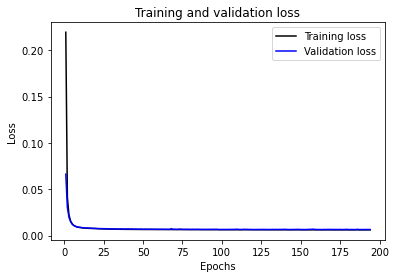

In [9]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b', color='k', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', color='b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()